In [1]:
import re
import cv2
import sys
import operator
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract as pt
from collections import Counter
from dateutil.parser import parse
pt.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [106]:
class date_finder():
    
    def __init__(self):
        self.pattern1 = r"(\d{1,4}([.'’~\-/])\d{1,2}([.'’~\-/])\d{1,4})"
        self.pattern2 = r"(\d{1,4}([.'’~\-/\s])[ADFJMNOSadfjmnos]\w*([.'’~\-/\s]*)\d{1,4})"
        self.pattern3 = r"([ADFJMNOSadfjmnos]\w*\s\d{1,4}([,'’~.\-/\s]*)([.'’~\-/\s])\d{1,4})"
        self.pattern4 = r"[ADFJMNOSadfjmnos]\w*\d{1,4}(['’]*)\d{1,4}"
        self.pattern5 = r"(\d{1,4}([.'’~\-/\s])\d{1,4}"
        self.dates = []
        
    def find_date(self, img_str):
        date_find = []
        for i in img_str:
            for j in (re.search(regex,i) for regex in [self.pattern1, self.pattern2, self.pattern3, self.pattern4]):
                if j:
                    s = j.group()
                    if s.find('.'):
                        date_find.append("-".join(s.split('.')))
                    else:
                        date_find.append(s)

        date_find = list(set(date_find))
        for i in date_find:
            try:
                i = i.replace("’","'")
                i = i.replace("’’","'")
                i = i.replace('"',"'")
                i = i.replace('~',"-")
                i = parse(i).strftime("%Y-%m-%d")
                if 1999 < int(i[:4]) < 2020:
                    self.dates.append(i)   
            except:
                continue
                
    def extract_img_str(self,path):
        config = ("-l eng --oem 1 --psm 3")
        filters = [3,5,7]
        for i in filters:
            gaussian_filter = (i,i)
            img = cv2.imread(path) 
            img = cv2.resize(img, None, fx = 3, fy = 3, interpolation=cv2.INTER_CUBIC) 
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_blur = cv2.GaussianBlur(img_gray, gaussian_filter, 0)
            img_str_1 = pt.image_to_string(Image.fromarray(img_blur),lang ="eng",config=config)
            img_str_1 = list(set(map(lambda x : x.strip(), img_str_1.split('\n'))))
            self.find_date(img_str_1)
            if self.dates:
                print('First: ',self.dates)
                continue

            img_str_2 = pt.image_to_string(path, lang='eng',config=config)
            img_str_2 = list(set(map(lambda x : x.strip(), img_str_2.split('\n'))))
            self.find_date(img_str_2)
            if self.dates:
                print('Second: ',self.dates)
                continue 

            ret,th1 = cv2.threshold(img_blur, 100, 225, cv2.THRESH_BINARY)
            img_str_3 = pt.image_to_string(Image.fromarray(th1), lang = 'eng',config=config)
            img_str_3 = list(set(map(lambda x : x.strip(), img_str_3.split('\n'))))
            self.find_date(img_str_3)
            if self.dates:
                print('Third: ',self.dates)
                continue 

            img_ad_thres = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
            img_str_4 = pt.image_to_string(Image.fromarray(img_ad_thres),lang='eng',config=config)
            img_str_4 = list(set(map(lambda x : x.strip(), img_str_4.split('\n'))))
            self.find_date(img_str_4)
            if self.dates:
                print('Forth: ',self.dates)
                continue 
        

# Load dates and convert them into specific format

In [91]:
def load_dataset():
    with open("all_image_dates.txt") as file:
        data = file.read()
    data = pd.DataFrame(data.replace(';','').split('\n'),index = range(1,596),columns = ['actual'])
    data['converted'] = None
    for i in data.actual[data.actual != 'null'].items():
        data.loc[i[0],'converted'] = parse(i[1]).strftime('%Y-%m-%d')    
    return data

In [92]:
data = load_dataset()
data.head()

,actual,converted
1,"May 21, 2019",2019-05-21
2,25-07-19,2019-07-25
3,"Sep 29, 2018",2018-09-29
4,Oct06' 16,2016-10-06
5,5/29/2019,2019-05-29


In [93]:
data['predicted'] = None

In [95]:
data.converted[data.converted.notnull()].index

Int64Index([  1,   2,   3,   4,   5,   6,   8,   9,  10,  11,
            ...
            583, 584, 585, 587, 588, 589, 590, 593, 594, 595],
           dtype='int64', length=516)

In [108]:
obj = date_finder()
obj.extract_img_str("images/104.jpeg")
d = {}
if obj.dates:
    l = obj.dates
    l = dict(Counter(l))
    date = max(l.items(), key=operator.itemgetter(1))[0]
    d['date'] = date
    print(d)
else:
    d['date'] = None
    print(d)

[]
{'date': None}


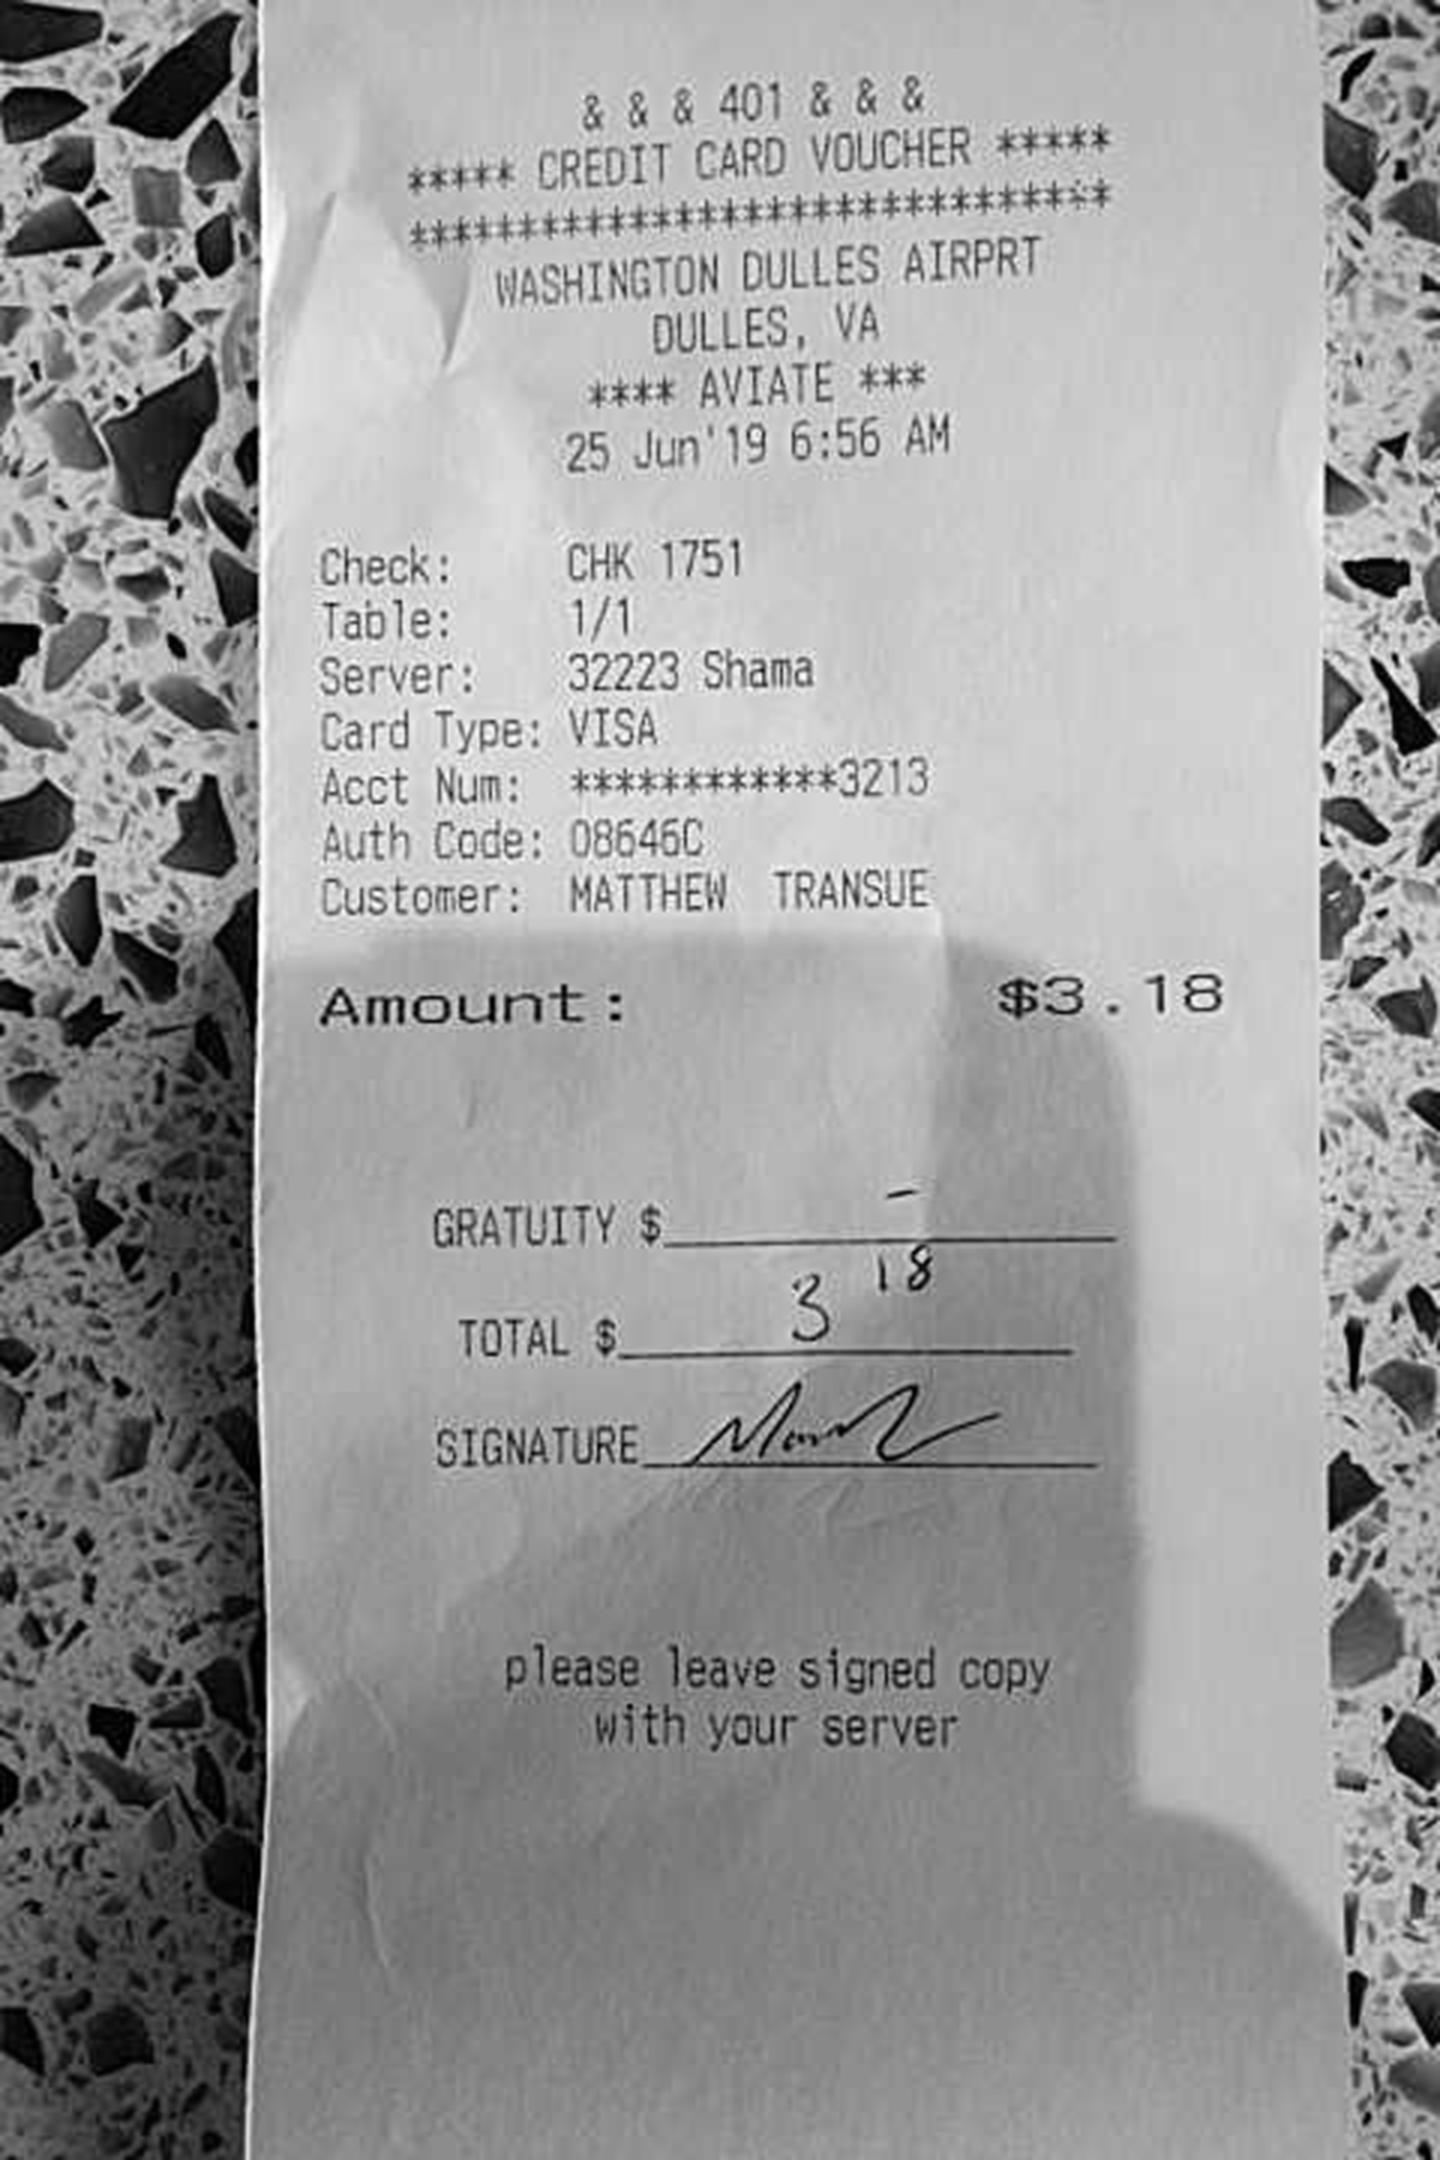

In [112]:
path = "images/104.jpeg"
config = ("-l eng --oem 1 --psm 3")
gaussian_filter = (3,3)
img = cv2.imread(path) 
img = cv2.resize(img, None, fx = 3, fy = 3, interpolation=cv2.INTER_CUBIC) 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, gaussian_filter, 0)
#img_str_1 = pt.image_to_string(Image.fromarray(img_blur),lang ="eng",config=config)
#img_str_1 = list(set(map(lambda x : x.strip(), img_str_1.split('\n'))))
#find_date(img_str_1)
#img_str_1
Image.fromarray(img_blur)

In [104]:
parse("14-06~2019")

ValueError: ('Unknown string format:', '14-06~2019')